# Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [2]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [3]:
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

## Learn H, A, T from Austin

In [4]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

### Transfer learning with A_au

In [ ]:
from scipy.optimize import nnls

pred_transfer = {}
T_adapt = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'


for random_seed in range(10):
    pred_transfer[random_seed] = {}
    T_adapt[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}


kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for adapt_percentage in range(10, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT(case, adapt_sd_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)

            T_adapt[random_seed][adapt_percentage][rd] = T_sd_adapt
            rd += 1
            
#             # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
#             test_sd_tensor = get_tensor(test_df, test_dfc)
#             # Get the aggregate information of test homes
#             aggregate_test = test_sd_tensor[:, 0, :]
#             # Use A_au from Austin and T_sd_adapt learn previous
#             AT_mat = np.einsum('ab, Ob -> aO', A_a[0], T_sd_adapt)
            
#             # Estimate Home factor H_test_mat for test homes
#             H_test_mat = np.zeros((len(test_df), 2))
#             for j in range(len(test_df)):
#                 mask_rows = pd.Series(aggregate_test[j,:]).notnull()
#                 H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
#             pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a, T_sd_adapt)
            
#             for appliance_name, appliance_id in appliance_index.iteritems():
#                 pred_transfer[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))

random seed:  0
adapt percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
adapt percentage:  100
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix

### Transfer learning with A_au, then update T with aggregate readings

In [5]:
def cost_update(H, A, T, E_np_masked):
    HA = np.einsum('Ma, ab -> Mb', H, A)
    HAT = np.einsum('Mb, Nb -> MN', HA, T)
    mask = ~np.isnan(E_np_masked)
    error = (HAT - E_np_masked)[mask].flatten()
    return np.sqrt((error ** 2).mean())

def update_T(E_np_masked, a, b, num_iter=2000, lr=0.1, dis=False, H_known=None,
             A_known=None,T_known=None):
    np.random.seed(0)
    cost = cost_update
    mg = multigrad(cost, argnums=[0, 1, 2])
    
    M, N = E_np_masked.shape
 
    H = np.random.rand(M, a)
    A = np.random.rand(a, b)
    T = np.random.rand(N, b)
    
    # initialize matrix H A T with known one.
    if H_known is not None:
        H = set_known(H, H_known)
    if A_known is not None:
        A = set_known(A, A_known)
    if T_known is not None:
        T = set_known(T, T_known)

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, E_np_masked)
        H -= lr * del_h
        A -= lr * del_a
        T -= lr * del_t

        # update T with A_known
        A = set_known(A, A_known)
        
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, E_np_masked_1))
    return H, A, T

In [8]:
from scipy.optimize import nnls

pred_transfer = {}
T_adapt = {}
T_adapt_agg = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'


for random_seed in range(10):
    pred_transfer[random_seed] = {}
    T_adapt[random_seed] = {}
    T_adapt_agg[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}


kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for adapt_percentage in range(10, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt[random_seed][adapt_percentage] = {}
        T_adapt_agg[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt_1 = learn_HAT(case, adapt_sd_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)
            T_adapt[random_seed][adapt_percentage][rd] = T_sd_adapt_1
            
            # update T with aggregate readings
            sd_aggregate = sd_tensor[:, 0, :]
            H_sd_adapt, A_sd_adapt, T_sd_adapt = update_T(sd_aggregate, a, a, num_iter=2000, 
                                                        lr=0.1, dis=False, A_known=A_a[0], T_known=T_sd_adapt_1)
            
            
            T_adapt_agg[random_seed][adapt_percentage][rd] = T_sd_adapt
            rd += 1
            
#             # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
#             test_sd_tensor = get_tensor(test_df, test_dfc)
#             # Get the aggregate information of test homes
#             aggregate_test = test_sd_tensor[:, 0, :]
#             # Use A_au from Austin and T_sd_adapt learn previous
#             AT_mat = np.einsum('ab, Ob -> aO', A_a[0], T_sd_adapt)
            
#             # Estimate Home factor H_test_mat for test homes
#             H_test_mat = np.zeros((len(test_df), 2))
#             for j in range(len(test_df)):
#                 mask_rows = pd.Series(aggregate_test[j,:]).notnull()
#                 H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
#             pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a, T_sd_adapt)
            
#             for appliance_name, appliance_id in appliance_index.iteritems():
#                 pred_transfer[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))

random seed:  0
adapt percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
adapt percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:

In [59]:
T = T_adapt[0][10][0]
for i in range(1, 10):
    T = T + T_adapt[0][10][i]
T = T/10
T

array([[ 2.3256582 ,  0.15612203],
       [ 2.24171955,  0.16532875],
       [ 2.21774683,  0.18804444],
       [ 2.4790195 ,  0.28534673],
       [ 2.3906688 ,  1.73778479],
       [ 2.59325903,  1.64470658],
       [ 1.54807911,  3.03709477],
       [ 1.71880663,  3.92907553],
       [ 1.89304722,  3.74757453],
       [ 1.99034373,  2.17798406],
       [ 2.43554863,  0.4722404 ],
       [ 2.39295005,  1.43008103]])

In [9]:
# T = []*10
T = []
T_agg = []
for per in range(10, 110, 10):
    T_temp = 0
    T_temp_agg = 0
    for random_seed in range(10):
        for rd in range(10):
            T_temp += T_adapt[random_seed][per][rd]
            T_temp_agg += T_adapt_agg[random_seed][per][rd]
    T_temp = T_temp/100
    T_temp_agg = T_temp_agg/100
    T.append(T_temp)
    T_agg.append(T_temp_agg)

In [62]:
T

[array([[ 1.61771461,  0.52649496],
        [ 1.68673765,  0.27279607],
        [ 1.96674336,  0.29577973],
        [ 2.08610375,  0.30296573],
        [ 2.0437184 ,  1.46274934],
        [ 2.38453801,  1.18419735],
        [ 1.60532218,  3.04960861],
        [ 1.53446995,  3.60641611],
        [ 1.3068633 ,  3.92283305],
        [ 2.07104692,  1.48303168],
        [ 1.85194297,  0.60632761],
        [ 2.44046892,  0.53728986]]), array([[ 2.85344875,  0.10620636],
        [ 2.54407143,  0.03961271],
        [ 2.71020277,  0.0848024 ],
        [ 2.77601243,  0.19943672],
        [ 2.3410592 ,  1.7107016 ],
        [ 2.53840508,  1.22228727],
        [ 1.74841137,  3.35164787],
        [ 1.67950636,  3.85348219],
        [ 1.57720409,  4.33561934],
        [ 2.3281962 ,  1.86229134],
        [ 2.63498756,  0.36906069],
        [ 3.25735553,  0.32021053]]), array([[ 3.2573924 ,  0.08817564],
        [ 2.87505526,  0.0475715 ],
        [ 3.08949488,  0.07600497],
        [ 3.13108191,  0.2

In [10]:
k = T[0].reshape(1, 24)
k_agg = T_agg[0].reshape(1, 24)
for i in range(1, 10):
    k = np.r_[k, T[i].reshape(1,24)]
    k_agg = np.r_[k_agg, T_agg[i].reshape(1,24)]
df_T = pd.DataFrame(k)
df_T_agg = pd.DataFrame(k_agg)

In [143]:
index=1
y_1 = df_T.loc[index:10].iloc[:, [0,2,4,6,8,10,12,14,16,18,20,22]]
y_2 = df_T.loc[index:10].iloc[:, [1,3,5,7,9,11,13,15,17,19,21,23]]

In [144]:
y_mean_1 = y_1.mean().values
y_mean_2 = y_2.mean().values
y_std_1 = y_1.std().values
y_std_2 = y_2.std().values

In [145]:
x_idx = [1,2,3,4,5,6,7,8,9,10,11,12]

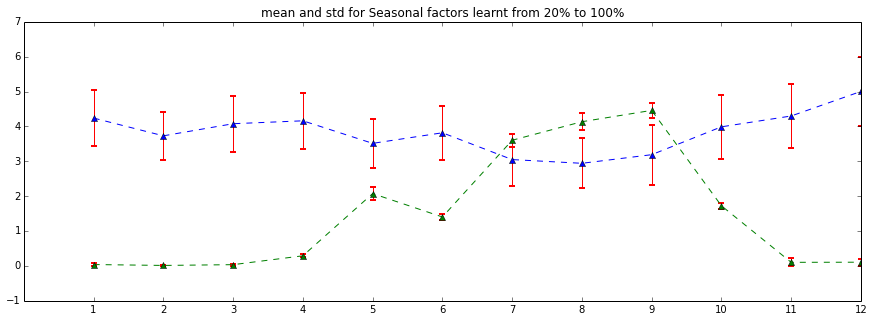

In [147]:
plt.figure(figsize=(15, 5))
plt.errorbar(x_idx, y_mean_1, yerr = y_std_1,  linestyle='--', fmt='^', ecolor='r', capthick=2)
plt.errorbar(x_idx, y_mean_2, yerr = y_std_2,  linestyle='--', fmt='^', ecolor='r', capthick=2)
plt.xticks(x_idx)
plt.title("mean and std for Seasonal factors learnt from 20% to 100%")

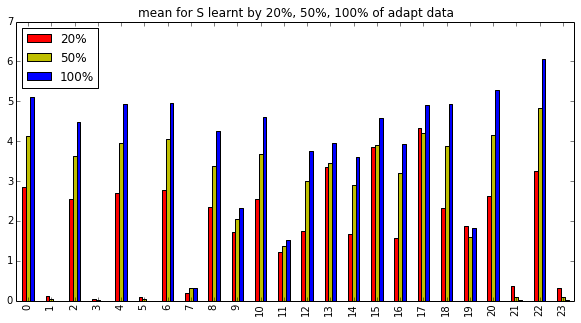

In [69]:
df_T.loc[[1, 4, 9]].T.rename(columns={1: "20%", 4:"50%", 9:"100%"}).plot(kind='bar', color=['r', 'y', 'b'], figsize=(10, 5))
# plt.legend([index, 9], ['20%', '100%'])
plt.title("mean for S learnt by 20%, 50%, 100% of adapt data")



In [11]:
df_T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.603803,0.513921,1.662227,0.257360,1.952273,0.282508,2.068387,0.283941,2.012732,1.428998,...,1.474871,3.535437,1.237621,3.844123,2.037261,1.446470,1.831638,0.589397,2.415752,0.512723
1,2.853449,0.106206,2.544071,0.039613,2.710203,0.084802,2.776012,0.199437,2.341059,1.710702,...,1.679506,3.853482,1.577204,4.335619,2.328196,1.862291,2.634988,0.369061,3.257356,0.320211
2,3.257392,0.088176,2.875055,0.047571,3.089495,0.076005,3.131082,0.267116,2.638579,1.958739,...,2.021825,4.117495,2.135035,4.452911,2.865883,1.791250,3.228189,0.181238,3.798292,0.200047
3,3.785232,0.044728,3.310110,0.020601,3.584186,0.059478,3.707828,0.272349,3.052224,2.008470,...,2.523147,3.991182,2.782736,4.287845,3.487665,1.671432,3.777724,0.115299,4.402783,0.139814
4,4.128828,0.049178,3.628858,0.015381,3.948054,0.051620,4.062950,0.322137,3.377505,2.045549,...,2.904345,3.921581,3.212049,4.205039,3.888908,1.606397,4.146512,0.100462,4.844323,0.095839
5,4.397101,0.030592,3.908012,0.002457,4.272329,0.025010,4.397592,0.295164,3.777689,2.034831,...,3.263329,3.992287,3.538408,4.312497,4.282847,1.662897,4.569899,0.075494,5.334769,0.073918
6,4.636988,0.027492,4.107370,0.000376,4.517114,0.017249,4.656992,0.311571,3.914359,2.139672,...,3.365816,4.111339,3.704205,4.400877,4.518025,1.683881,4.821869,0.050262,5.574566,0.058401
7,4.945728,0.008415,4.321256,0.000000,4.773346,0.010952,4.835564,0.326058,4.085971,2.220796,...,3.515114,4.276580,3.883082,4.566345,4.711194,1.688143,5.033517,0.021417,5.815033,0.027993
8,5.051851,0.002607,4.406295,0.000000,4.869007,0.002291,4.913552,0.314042,4.186837,2.239395,...,3.604272,4.361937,3.951080,4.670125,4.871933,1.737320,5.199090,0.012998,5.932555,0.027310
9,5.097070,0.000000,4.472993,0.000000,4.936510,0.000000,4.968276,0.307655,4.257152,2.311399,...,3.607275,4.590381,3.924187,4.911531,4.942907,1.825625,5.280341,0.002857,6.066424,0.017234


In [12]:
df_T_agg

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,5.039195,0.063171,4.420310,0.068701,4.606563,0.142226,3.996071,0.802474,1.739828,4.252510,...,0.318866,7.306692,0.320960,7.857855,3.277397,3.144320,4.211758,0.760609,4.725036,1.017602
1,5.046864,0.071369,4.427589,0.077659,4.621673,0.160773,4.016605,0.826552,1.766916,4.284200,...,0.360481,7.361172,0.362820,7.912763,3.297660,3.170162,4.227187,0.780051,4.742330,1.039432
2,5.006932,0.028816,4.389466,0.031356,4.543290,0.064917,3.910018,0.702282,1.624977,4.122132,...,0.145609,7.080852,0.146525,7.630526,3.194152,3.036056,4.149265,0.678079,4.655793,0.924306
3,5.059775,0.086403,4.440074,0.094014,4.648810,0.194658,4.053229,0.870994,1.817245,4.342395,...,0.437074,7.463072,0.439609,8.015509,3.336705,3.216550,4.257541,0.813791,4.777521,1.076424
4,5.101186,0.131582,4.479733,0.143147,4.731489,0.296431,4.165699,1.003213,1.968053,4.515491,...,0.666421,7.762855,0.669990,8.317501,3.448242,3.358406,4.342532,0.920237,4.872985,1.195842
5,5.104636,0.135653,4.483086,0.147557,4.738881,0.305583,4.175478,1.015374,1.982533,4.530912,...,0.687457,7.791078,0.691146,8.346020,3.459128,3.370992,4.351098,0.929183,4.883157,1.205466
6,5.095526,0.126058,4.474385,0.137128,4.721029,0.283986,4.151384,0.987283,1.950144,4.494475,...,0.638838,7.727567,0.642113,8.282158,3.435438,3.340824,4.333445,0.906109,4.863480,1.179467
7,5.032909,0.058920,4.414539,0.064100,4.597437,0.132745,3.983440,0.790969,1.726099,4.237768,...,0.298572,7.283770,0.300115,7.835382,3.270930,3.129434,4.209088,0.746099,4.724758,0.999233
8,4.993311,0.016444,4.376694,0.017891,4.519270,0.037049,3.877185,0.666776,1.584434,4.075328,...,0.083319,7.003037,0.083755,7.552757,3.166898,2.995689,4.130430,0.644871,4.637028,0.885201
9,4.978328,0.000000,4.362321,0.000000,4.489139,0.000000,3.836564,0.618358,1.528529,4.012908,...,0.000000,6.893133,0.000000,7.441975,3.125900,2.944115,4.099137,0.606366,4.601500,0.842312


In [32]:
index=8

df = pd.concat([pd.DataFrame(T[index], columns={"transfer_factor_0", "transfer_factor_1"}), 
                pd.DataFrame(T_agg[index], columns={"transfer_aggregate_factor_0", "transfer_aggregate_factor_1"})], axis=1)

In [33]:
df

,transfer_factor_1,transfer_factor_0,transfer_aggregate_factor_1,transfer_aggregate_factor_0
0,5.051851,0.002607,4.993311,0.016444
1,4.406295,0.000000,4.376694,0.017891
2,4.869007,0.002291,4.519270,0.037049
3,4.913552,0.314042,3.877185,0.666776
4,4.186837,2.239395,1.584434,4.075328
5,4.509432,1.484016,0.444995,4.532790
6,3.728191,3.777107,0.075790,6.532415
7,3.604272,4.361937,0.083319,7.003037
8,3.951080,4.670125,0.083755,7.552757
9,4.871933,1.737320,3.166898,2.995689


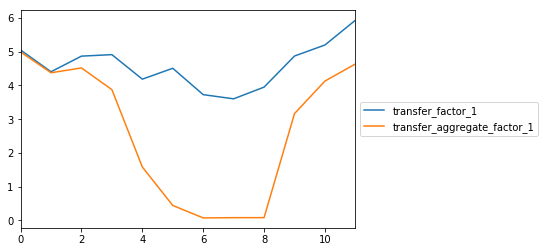

In [34]:
ax = df.iloc[:, [0, 2]].plot()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

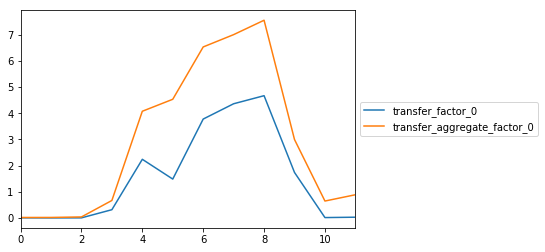

In [35]:
ax = df.iloc[:, [1, 3]].plot()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

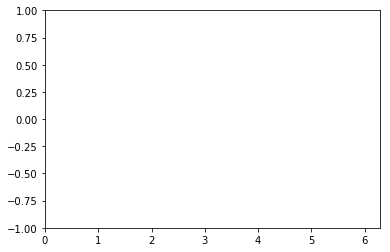

ValueError: I/O operation on closed file

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# plt.rcParams['animation.ffmpeg_path'] = ""
plt.rcParams['animation.ffmpeg_path']=unicode('/usr/local/bin/ffmpeg')

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro', animated=True)

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()
ani.save('test.gif', dpi=80, writer='imagemagick')

In [51]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

x = np.linspace(-2, 2, 200)

duration = 2

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.plot(x, np.sinc(x**2) + np.sin(x + 2*np.pi/duration * t), lw=3)
    ax.set_ylim(-1.5, 2.5)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.write_gif('matplotlib.gif', fps=30)

ImportError: No module named moviepy.editor